# Initial Steps:

1. Import the 'subprocess' package and set path variables.
2. Configure NS-3 suitably.
3. Build NS-3.

You need to do this only once for building the program.

In [1]:
# System import
import subprocess as shell
import os

# Variables for source directory and .waf command.
SOURCE_DIR = "/home/sachin/repos/ns-3-dev/"
WAF_COMMAND = SOURCE_DIR + "/waf"
CONF_PARAMS = ' --enable-examples --enable-tests --enable-sudo --disable-python configure'

In [2]:
# Perform configuration and build
os.chdir(SOURCE_DIR)
print("Configure NS-3.")
shell.run(WAF_COMMAND + CONF_PARAMS, shell=True)
print("Build NS-3.")
shell.run(WAF_COMMAND)

Configure NS-3.
Build NS-3.


CompletedProcess(args='/home/sachin/repos/ns-3-dev//waf', returncode=0)

# Stuff for Plotting

Get the imports for plotting stuff in Python and write the functions to parse NS-3 outputs.

In [3]:
# Imports for plotting
import sys
import matplotlib
import matplotlib.pyplot as plt
import math

# Paths for log and stats files.
UE_MEAS_FILE = SOURCE_DIR + "lena-handover-simple-ue-measurements.dat"
UE_SINR_FILE = SOURCE_DIR + "DlRsrpSinrStats.txt"

In [14]:
# Extract RSRP, RSRQ and SINR from log files.
def get_RSRP_RSRQ_SINR(num_eNBs):
    
    # Variables for parsing Measurement reports at eNB
    eNB_times = [[] for _ in range(num_eNBs)]
    RSRPs = [[] for _ in range(num_eNBs)]
    RSRQs = [[] for _ in range(num_eNBs)]

    # Variables for parsing SINR calculated at the single UE
    UE_times = []
    SINRs = []
    
    # Iterate over each line in the 'ue-measurements' file.
    fd = open(UE_MEAS_FILE, 'r')
    for line in fd:
        l = line.split()
        if line.startswith("#"):
            continue
        eNB_num = int(l[2]) - 1
        if eNB_num >= 0:
            eNB_times[eNB_num].append(float(l[0]))
            RSRPs[eNB_num].append(float(l[4]))
            RSRQs[eNB_num].append(float(l[5]))
    fd.close()
        
    # Iterate over each line in the 'DlRsrpSinrStats' file.
    fd = open(UE_SINR_FILE, 'r')
    for line in fd:
        l = line.split()
        if line.startswith("%"):
            continue            
        UE_times.append(float(l[0]))
        SINRs.append(10*math.log10(float(l[5])))
    fd.close()
    
    return eNB_times, RSRPs, RSRQs, UE_times, SINRs

# Plot extracted RSRP, RSRQ and SINR.
def plot_RSRP_RSRQ_SINR(eNB_times, RSRPs, RSRQs, UE_times, SINRs, num_eNBs):
    
    # Check if the UE-measurements are generated correctly.
    if len(eNB_times[0]) == 0:
        print("No data points found in 'UE-measurements file', exiting...")
        return
    
    # Create a subplot with 3 rows for each of RSRP, RSRQ and SINR.
    fig, axs = plt.subplots(3, 1, figsize=(15,20))
    
    # Plot the RSRP and RSRQ values.
    for i in range(num_eNBs):
        axs[0].scatter(eNB_times[i], RSRPs[i], marker='o', label='cell ' + str(i))
        axs[1].scatter(eNB_times[i], RSRQs[i], marker='o', label='cell ' + str(i))
    
    # Label and show legends for RSRP/RSRQ plots.
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('RSRP (dBm)')
    axs[0].set_title('RSRP Plot for Cells [dBm]')
    axs[0].grid()
    axs[0].legend()
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('RSRQ (dBm)')
    axs[1].set_title('RSRQ Plot for Cells [dBm]')    
    axs[1].grid()
    axs[1].legend()
    
    # Plot the SINR values and label.
    axs[2].scatter(UE_times, SINRs, marker='o')    
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('SINR (dB)')
    axs[2].set_title('SINR Plot for Single UE [dB]')
    axs[2].grid()    
    
    return fig, axs

# LENA-HANDOVER-SIMPLE

![simple_topology](Images/Topology.png)

We run a modified version of 'lena-x2-handover-measures' with different simulation and HO optimization parameters to observe the below.

1. Successful handover (HO) of user entities (UEs) between base stations (eNBs)
2. Handover failure due to radio link failure (RLF) resulting from low SINR

![A3_Relation](Images/A3_Relation.png)

Can we verify the easier metric in the below image first?

![HF](Images/HF.png)

In [5]:
# Variables for running the program.

# Path to built program
BUILD_DIR = "./build/scratch/lena-handover-simple/lena-handover-simple"
RUN_COMMAND = "/home/sachin/repos/ns-3-dev/waf --run-no-build=\"lena-handover-simple\""

# Parameters for simulation; base: 'lena-x2-handover-measures.cc'
NUM_ENBS = 2
NUM_BEARERS = 1
SIM_PARAMS = " -y_for_UE=1200 -inter_eNB_dist=1200 -neNBs=" + str(NUM_ENBS) + " -nBearers=" + str(NUM_BEARERS)

# HO parameters for successful HO and RLF; #36.331
HO_PARAM_SUCCESS = " -speed=20 -timeToTrigger=40"
HO_PARAM_RLF = " -speed=200 -timeToTrigger=256"

# Parameters for RLF. #36.331
T310 = 50             # [ms] standards limit to {0, 50, 100, 200, 500, 1000, 2000}; default to small value of 50 ms but ns-3 defaults to 1000 ms; time after which radio problem detection and no radio recovery to indicate RLF
N310 = 1              # standards limit to {1, 2, 3, 4, 6, 8, 10, 20}; default to one out-of-sync indication but ns-3 defaults to 6; N310 out-of-sync indications leads to radio problem detection at UE
N311 = 1              # standards limit to {1, 2, 3, 4, 6, 8, 10}; default to one in-sync indication but ns-3 defaults to 2; N311 in-sync indications leads to radio recovery at UE
Qout = -5             # [dB] set to ns-3 default of -5 dB; 36.839 sets it to -8 dB
Qin = -3.9            # [dB] set to ns-3 default of -3.9 dB; 36.839 sets it to -6 dB
numQoutEvalSf = 20    # [ms] number of subframes of 1 ms each; set to small value for quick detection; numQoutEvalSf is defined as TEval_Qout in #36.133
numQinEvalSf = 10     # [ms] number of subframes of 1 ms each; set to small value for quick detection; numQinEvalSf is defined as TEval_Qin in #36.133
RLF_PARAMS = " -qOut=" + str(Qout) + " -qIn=" + str(Qin) + " -numQoutEvalSf=" + str(numQoutEvalSf) + " -numQinEvalSf=" + str(numQinEvalSf) + " -t310=" + str(T310) + " -n310=" + str(N310) + " -n311=" + str(N311)  

# Commands for successful HO and RLF for running interactively; under construction
COMMAND_SUCCESS = BUILD_DIR + HO_PARAM_SUCCESS + SIM_PARAMS + RLF_PARAMS
COMMAND_RLF = BUILD_DIR + HO_PARAM_RLF + SIM_PARAMS + RLF_PARAMS

# Single run commands for RLF/HO
RUN_COMMAND_SUCCESS = RUN_COMMAND + HO_PARAM_SUCCESS + SIM_PARAMS + RLF_PARAMS + "\""
RUN_COMMAND_RLF = RUN_COMMAND + HO_PARAM_RLF + SIM_PARAMS + RLF_PARAMS + "\""

# ENCODING for decoding byte stream
ENCODING = "utf-8"

In [9]:
# Run the HO simulation with parameters for successful HO.
print("Run with TTT = 40ms and speed = 20m/s for successful HO.")
out_HO = shell.check_output(RUN_COMMAND_SUCCESS, shell=True).decode(ENCODING).split('\n')[1:-1]
print(out_HO)

Run with TTT = 40ms and speed = 20m/s for successful HO.
['UE_EST_CONNECTION: IMSI-1 CellId-1 RNTI-1 Time-0.268', 'ENB_EST_CONNECTION: IMSI-1 CellId-1 RNTI-1 Time-0.279929', 'ENB_START_HO: IMSI-1 SCellId-1 TCellId-2 RNTI-1 Time-100.45', 'UE_HO_START: IMSI-1 SCellId-1 TCellId-2 RNTI-1 Time-100.455', 'UE_HO_END: IMSI-1 TCellId-2 RNTI-1 Time-100.458', 'ENB_END_HO: IMSI-1 TCellId-2 RNTI-1 Time-100.47']


In [10]:
# Extract the logs into relevant lists.
HO_eNB_times, HO_RSRPs, HO_RSRQs, HO_UE_times, HO_SINRs = get_RSRP_RSRQ_SINR(NUM_ENBS)

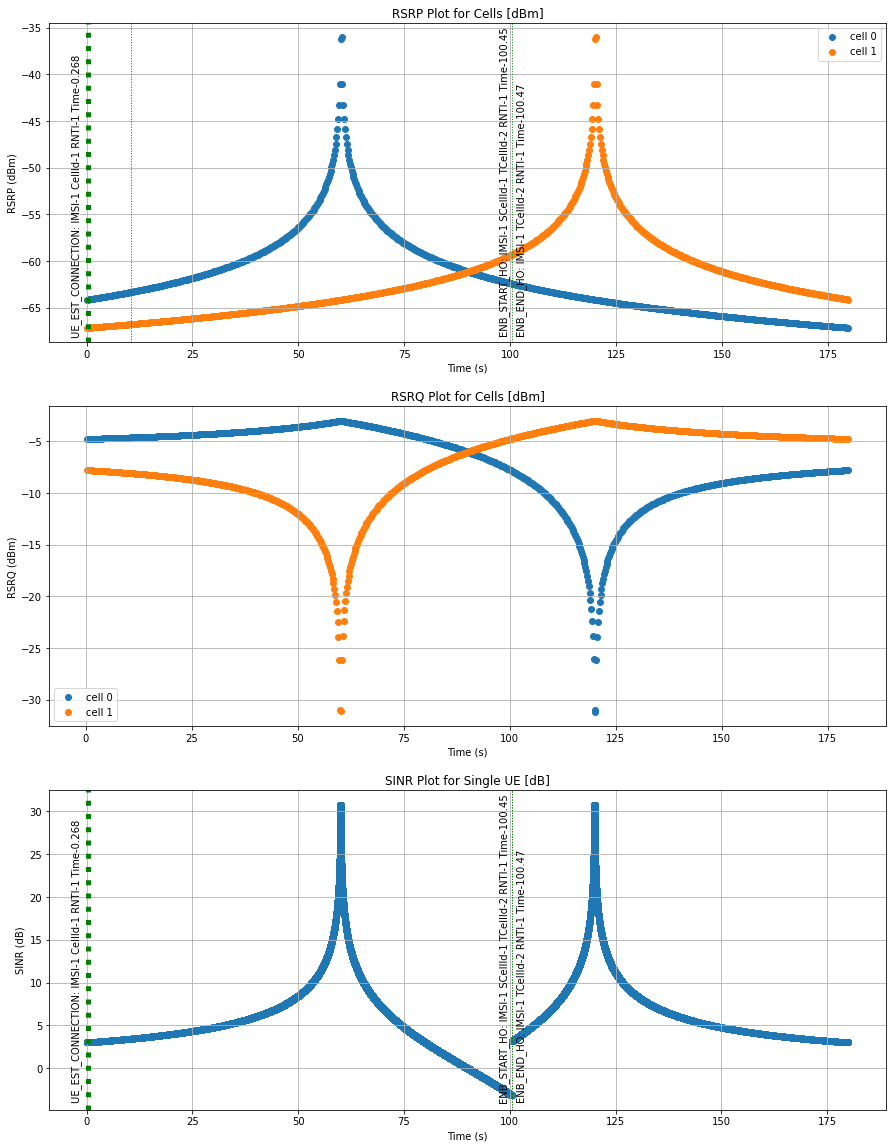

In [108]:
# Plot the RSRP, RSRQ and SINR into the figure.
HO_Success_figure, HO_Success_axes = plot_RSRP_RSRQ_SINR(HO_eNB_times, HO_RSRPs, HO_RSRQs, HO_UE_times, HO_SINRs, NUM_ENBS)

# Text and numbers for plotting.
text_HO = []
num_HO = []

# Establish connection.
est_conn = out_HO[0].split()
text_HO.append(out_HO[0])
num_HO.append(float(est_conn[4].split('-')[1]))

# eNB start HO.
eNB_start_HO = out_HO[2].split()
text_HO.append(out_HO[2])
num_HO.append(float(eNB_start_HO[5].split('-')[1]))

# eNB end HO.
eNB_end_HO = out_HO[5].split()
text_HO.append(out_HO[5])
num_HO.append(float(eNB_end_HO[4].split('-')[1]))

# Add all the vertical lines and labels.
HO_Success_axes[0].axvline(x=num_HO[0],linewidth=5,linestyle=':',color='g')
HO_Success_axes[0].text(num_HO[0]-4,-53,text_HO[0],rotation=90,verticalalignment='center')
HO_Success_axes[0].axvline(x=num[1],linewidth=1,linestyle=':',color='g')
HO_Success_axes[0].text(num_HO[1]-3,-51.5,text_HO[1],rotation=90,verticalalignment='center')
HO_Success_axes[0].axvline(x=num_HO[2],linewidth=1,linestyle=':',color='g')
HO_Success_axes[0].text(num_HO[2]+1,-54.5,text_HO[2],rotation=90,verticalalignment='center')
HO_Success_axes[2].axvline(x=num_HO[0],linewidth=5,linestyle=':',color='g')
HO_Success_axes[2].text(num_HO[0]-4,12.5,text_HO[0],rotation=90,verticalalignment='center')
HO_Success_axes[2].axvline(x=num_HO[1],linewidth=1,linestyle=':',color='g')
HO_Success_axes[2].text(num_HO[1]-3,14,text_HO[1],rotation=90,verticalalignment='center')
HO_Success_axes[2].axvline(x=num_HO[2],linewidth=1,linestyle=':',color='g')
HO_Success_axes[2].text(num_HO[2]+1,10.8,text_HO[2],rotation=90,verticalalignment='center');

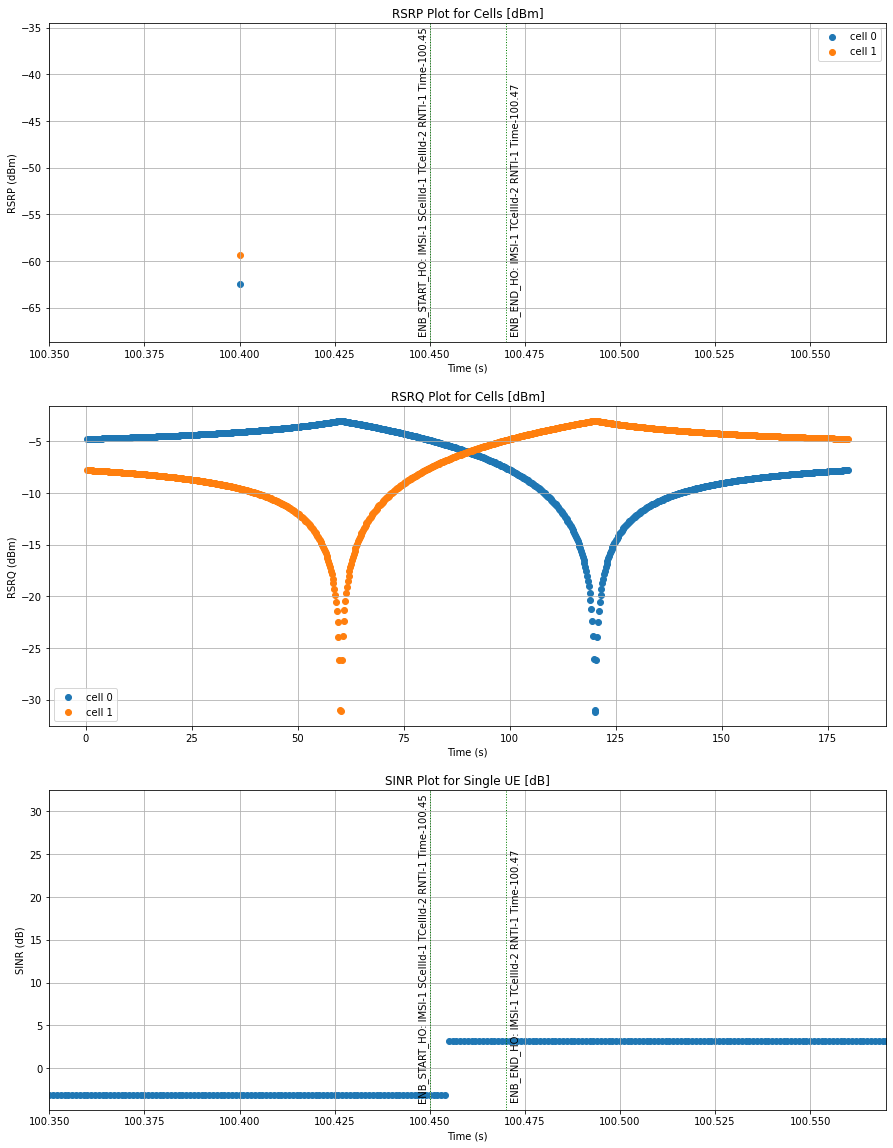

In [109]:
# Create new zoomed in plot.
Zoom_HO_figure, Zoom_HO_axes = plot_RSRP_RSRQ_SINR(HO_eNB_times, HO_RSRPs, HO_RSRQs, HO_UE_times, HO_SINRs, NUM_ENBS)

# Add all the vertical lines and labels.
Zoom_HO_axes[0].axvline(x=num_HO[1],linewidth=1,linestyle=':',color='g')
Zoom_HO_axes[0].text(num_HO[1]-0.003,-51.5,text_HO[1],rotation=90,verticalalignment='center')
Zoom_HO_axes[0].axvline(x=num_HO[2],linewidth=1,linestyle=':',color='g')
Zoom_HO_axes[0].text(num_HO[2]+0.001,-54.5,text_HO[2],rotation=90,verticalalignment='center')
Zoom_HO_axes[2].axvline(x=num_HO[1],linewidth=1,linestyle=':',color='g')
Zoom_HO_axes[2].text(num_HO[1]-0.003,14,text_HO[1],rotation=90,verticalalignment='center')
Zoom_HO_axes[2].axvline(x=num_HO[2],linewidth=1,linestyle=':',color='g')
Zoom_HO_axes[2].text(num_HO[2]+0.001,10.8,text_HO[2],rotation=90,verticalalignment='center')

# Zoom in appropriately.
Zoom_HO_axes[0].set_xlim(num_HO[1]-0.1,num_HO[2]+0.1);
Zoom_HO_axes[2].set_xlim(num_HO[1]-0.1,num_HO[2]+0.1);

In [21]:
# Run the HO simulation with parameters for RLF.
print("Run with TTT = 256ms and speed = 200m/s for RLF.")
out_RLF = shell.check_output(RUN_COMMAND_RLF, shell=True).decode(ENCODING).split('\n')[1:-1]
print(out_RLF)

Run with TTT = 256ms and speed = 200m/s for RLF.
['UE_EST_CONNECTION: IMSI-1 CellId-1 RNTI-1 Time-0.268', 'ENB_EST_CONNECTION: IMSI-1 CellId-1 RNTI-1 Time-0.279929', 'OUT_OF_SYNC: IMSI-1 RNTI-1 CellId-1 Count-1 Time-10.5772', 'RLF_DETECTED: IMSI-1 X-2125.44 Y-1200 RNTI-1 CellId-1 Time-10.6272', 'UE_EST_CONNECTION: IMSI-1 CellId-2 RNTI-1 Time-10.828', 'ENB_EST_CONNECTION: IMSI-1 CellId-2 RNTI-1 Time-10.8399']


In [22]:
# Extract the logs into relevant lists.
RLF_eNB_times, RLF_RSRPs, RLF_RSRQs, RLF_UE_times, RLF_SINRs = get_RSRP_RSRQ_SINR(NUM_ENBS)

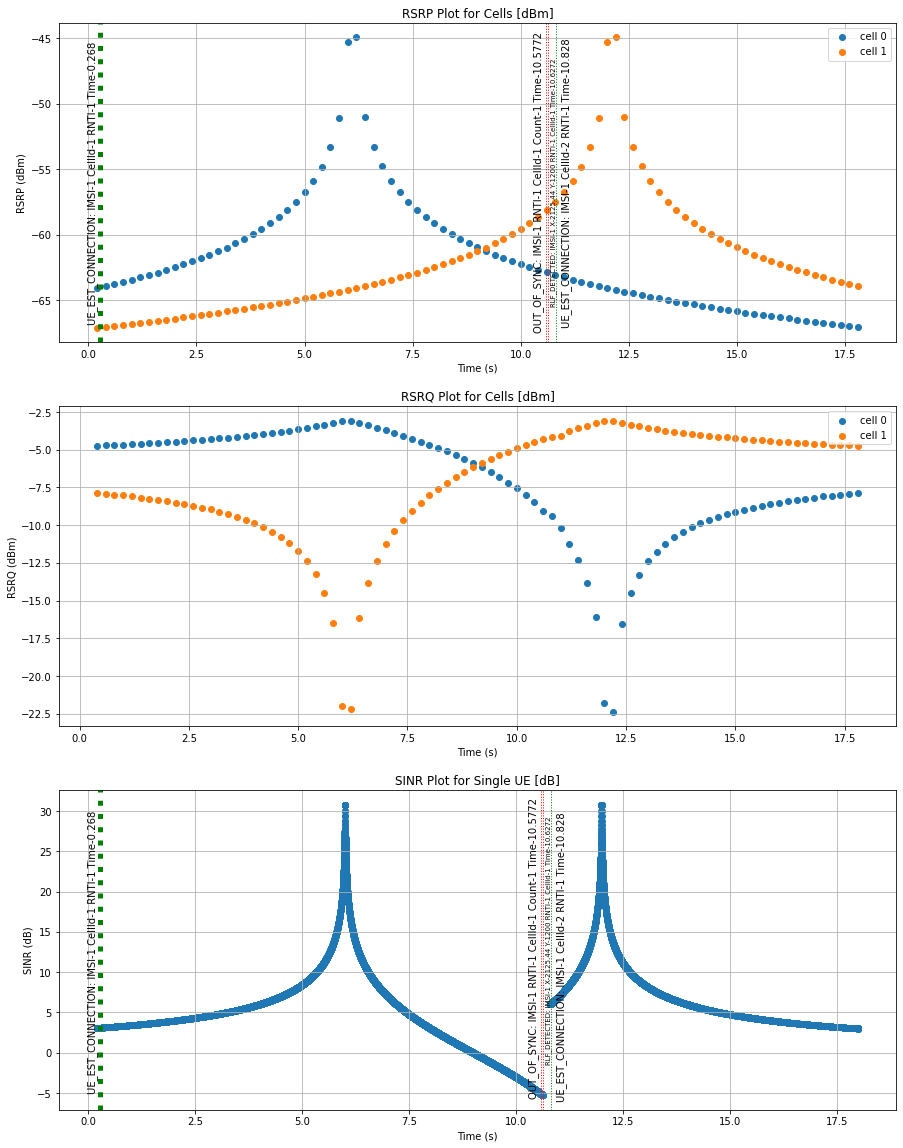

In [113]:
# Plot the RSRP, RSRQ and SINR into the figure.
RLF_figure, RLF_axes = plot_RSRP_RSRQ_SINR(RLF_eNB_times, RLF_RSRPs, RLF_RSRQs, RLF_UE_times, RLF_SINRs, NUM_ENBS)

# Text and numbers for plotting.
text_RLF = []
num_RLF = []

# Establish connection.
est_conn1 = out_RLF[0].split()
text_RLF.append(out_RLF[0])
num_RLF.append(float(est_conn1[4].split('-')[1]))
est_conn2 = out_RLF[4].split()
text_RLF.append(out_RLF[4])
num_RLF.append(float(est_conn2[4].split('-')[1]))

# Out-of-sync indication and RLF detection
phy_sync = out_RLF[2].split()
text_RLF.append(out_RLF[2])
num_RLF.append(float(phy_sync[5].split('-')[1]))
rlf_detected = out_RLF[3].split()
text_RLF.append(out_RLF[3])
num_RLF.append(float(rlf_detected[6].split('-')[1]))

# Add all the vertical lines and labels.
RLF_axes[0].axvline(x=num_RLF[0],linewidth=5,linestyle=':',color='g')
RLF_axes[0].text(num_RLF[0]-0.3,-56,text_RLF[0],rotation=90,verticalalignment='center')
RLF_axes[0].axvline(x=num_RLF[1],linewidth=1,linestyle=':',color='g')
RLF_axes[0].text(num_RLF[1]+0.1,-56,text_RLF[1],rotation=90,verticalalignment='center')
RLF_axes[0].axvline(x=num_RLF[2],linewidth=1,linestyle=':',color='r')
RLF_axes[0].text(num_RLF[2]-0.3,-56,text_RLF[2],rotation=90,verticalalignment='center')
RLF_axes[0].axvline(x=num_RLF[3],linewidth=1,linestyle=':',color='r')
RLF_axes[0].text(num_RLF[3]+0.05,-56,text_RLF[3],rotation=90,verticalalignment='center',fontsize=7)
RLF_axes[2].axvline(x=num_RLF[0],linewidth=5,linestyle=':',color='g')
RLF_axes[2].text(num_RLF[0]-0.3,12.5,text_RLF[0],rotation=90,verticalalignment='center')
RLF_axes[2].axvline(x=num_RLF[1],linewidth=1,linestyle=':',color='g')
RLF_axes[2].text(num_RLF[1]+0.1,12,text_RLF[1],rotation=90,verticalalignment='center')
RLF_axes[2].axvline(x=num_RLF[2],linewidth=1,linestyle=':',color='r')
RLF_axes[2].text(num_RLF[2]-0.3,13,text_RLF[2],rotation=90,verticalalignment='center')
RLF_axes[2].axvline(x=num_RLF[3],linewidth=1,linestyle=':',color='r')
RLF_axes[2].text(num_RLF[3]+0.05,14,text_RLF[3],rotation=90,verticalalignment='center',fontsize=7);

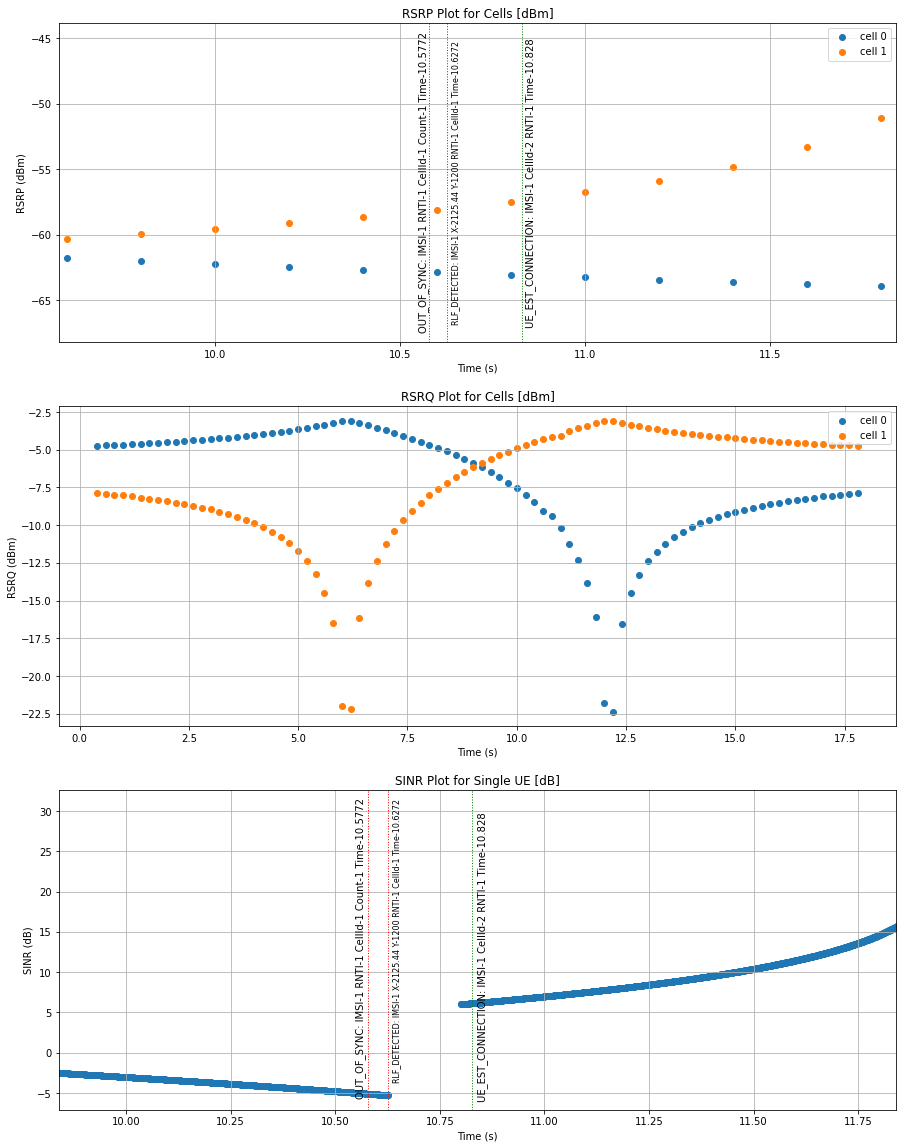

In [131]:
# Create new zoomed in plot.
Zoom_RLF_figure, Zoom_RLF_axes = plot_RSRP_RSRQ_SINR(RLF_eNB_times, RLF_RSRPs, RLF_RSRQs, RLF_UE_times, RLF_SINRs, NUM_ENBS)

# Add all the vertical lines and labels.
Zoom_RLF_axes[0].axvline(x=num_RLF[1],linewidth=1,linestyle=':',color='g')
Zoom_RLF_axes[0].text(num_RLF[1]+0.01,-56,text_RLF[1],rotation=90,verticalalignment='center')
Zoom_RLF_axes[0].axvline(x=num_RLF[2],linewidth=1,linestyle=':',color='r')
Zoom_RLF_axes[0].text(num_RLF[2]-0.03,-56,text_RLF[2],rotation=90,verticalalignment='center')
Zoom_RLF_axes[0].axvline(x=num_RLF[3],linewidth=1,linestyle=':',color='r')
Zoom_RLF_axes[0].text(num_RLF[3]+0.01,-56,text_RLF[3],rotation=90,verticalalignment='center',fontsize=8)
Zoom_RLF_axes[2].axvline(x=num_RLF[1],linewidth=1,linestyle=':',color='g')
Zoom_RLF_axes[2].text(num_RLF[1]+0.01,12,text_RLF[1],rotation=90,verticalalignment='center')
Zoom_RLF_axes[2].axvline(x=num_RLF[2],linewidth=1,linestyle=':',color='r')
Zoom_RLF_axes[2].text(num_RLF[2]-0.03,13,text_RLF[2],rotation=90,verticalalignment='center')
Zoom_RLF_axes[2].axvline(x=num_RLF[3],linewidth=1,linestyle=':',color='r')
Zoom_RLF_axes[2].text(num_RLF[3]+0.01,14,text_RLF[3],rotation=90,verticalalignment='center',fontsize=8);

# Zoom in appropriately.
Zoom_RLF_axes[0].set_xlim(num[1]-1,num[2]+1);
Zoom_RLF_axes[2].set_xlim(num[2]-1,num[2]+1);